# Amazon Stock Price Dataset Description

## Overview
The Amazon stock price dataset contains historical daily stock price data for Amazon.com Inc. (ticker symbol: AMZN). The dataset includes information such as the opening price, closing price, highest price, lowest price, and trading volume for each trading day.

## Data Source
The data was sourced from [Kaggle](https://www.kaggle.com/datasets/henryshan/amazon-com-inc-amzn), covering several years of trading history for Amazon stock.

## Dataset Columns
The dataset consists of the following columns:
- **Date**: The date of the trading day.
- **Open**: The opening price of the stock on the trading day.
- **High**: The highest price of the stock during the trading day.
- **Low**: The lowest price of the stock during the trading day.
- **Close**: The closing price of the stock on the trading day.
- **Adj Close**: The adjusted closing price of the stock, adjusted for dividends and stock splits.
- **Volume**: The trading volume of the stock on the trading day.

## Purpose
The dataset is valuable for analyzing the historical performance of Amazon stock, identifying trends, and conducting technical analysis. It can be used by investors, financial analysts, data scientists, and researchers for various purposes such as trend prediction, volatility analysis, and backtesting of trading strategies.

## Usage
Researchers and analysts can use this dataset to perform a wide range of analyses, including:
- Time series forecasting to predict future stock prices.
- Correlation analysis with other financial instruments or economic indicators.
- Identification of patterns and trends using techniques such as moving averages, candlestick patterns, and momentum indicators.
- Backtesting of trading strategies to evaluate their performance over historical data.

# Table of Contents

1. [Introduction](#introduction)
2. [Required Libraries](#libraries)
3. [Getting Data](#get-data)
4. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
5. [Data Preprocessing](#Data-Preprocessing)
6. [Model Development & Evaluation](#Model-Development)
7. [Models Comparision](#Models-Comparision)

# <div id="libraries">Required Libraries</div>

In [4]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions import create_tensorboard_callback, check_tf_gpu
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
check_tf_gpu()

No GPU was detected. Neural nets can be very slow without a GPU.


# <div id="get-data">Getting Data</div>

In [13]:
df = pd.read_csv('../data/external/AmazonStockPrice.csv',
                 parse_dates=['Date'], index_col='Date')

df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

df=df.drop_duplicates()

In [14]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1.443120e+09
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,2.940000e+08
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,1.221360e+08
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,1.093440e+08
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,3.770640e+08


# <div id="Exploratory-Data-Analysis-(EDA)">Exploratory-Data-Analysis-(EDA)</div>

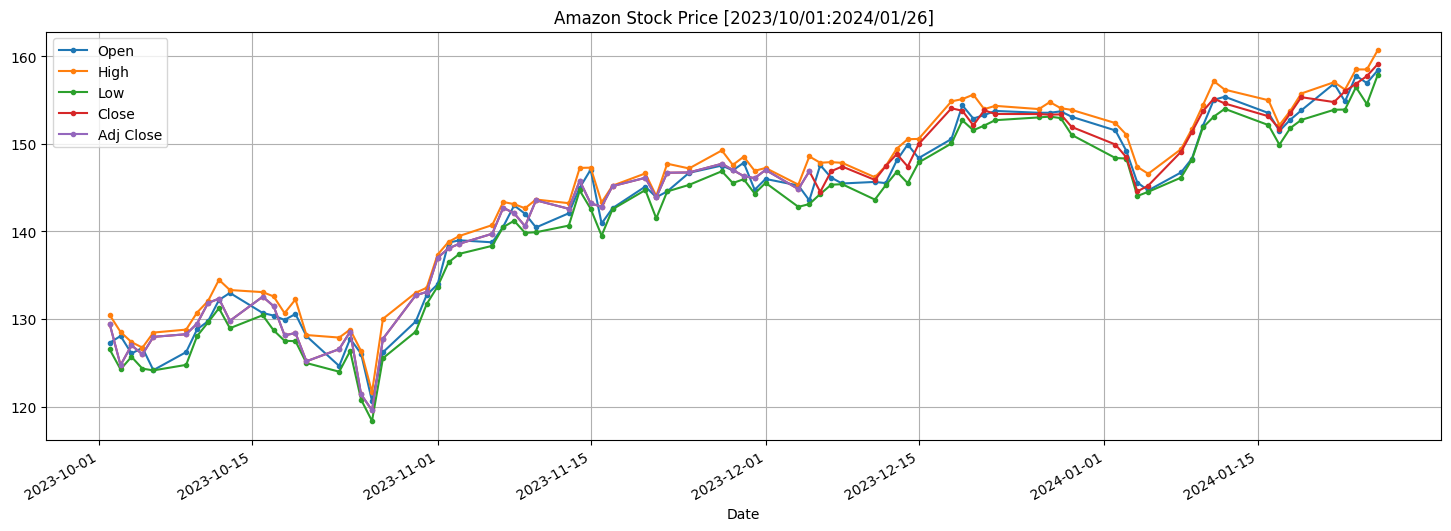

In [16]:
df["2023-10-01":"2024-01-26"].drop(['Volume'],axis=1).plot(grid=True,marker='.',figsize=(18,6),title='Amazon Stock Price [2023/10/01:2024/01/26]')
plt.savefig('../reports/figures/Stock Price [2023-2024].png',dpi=300)

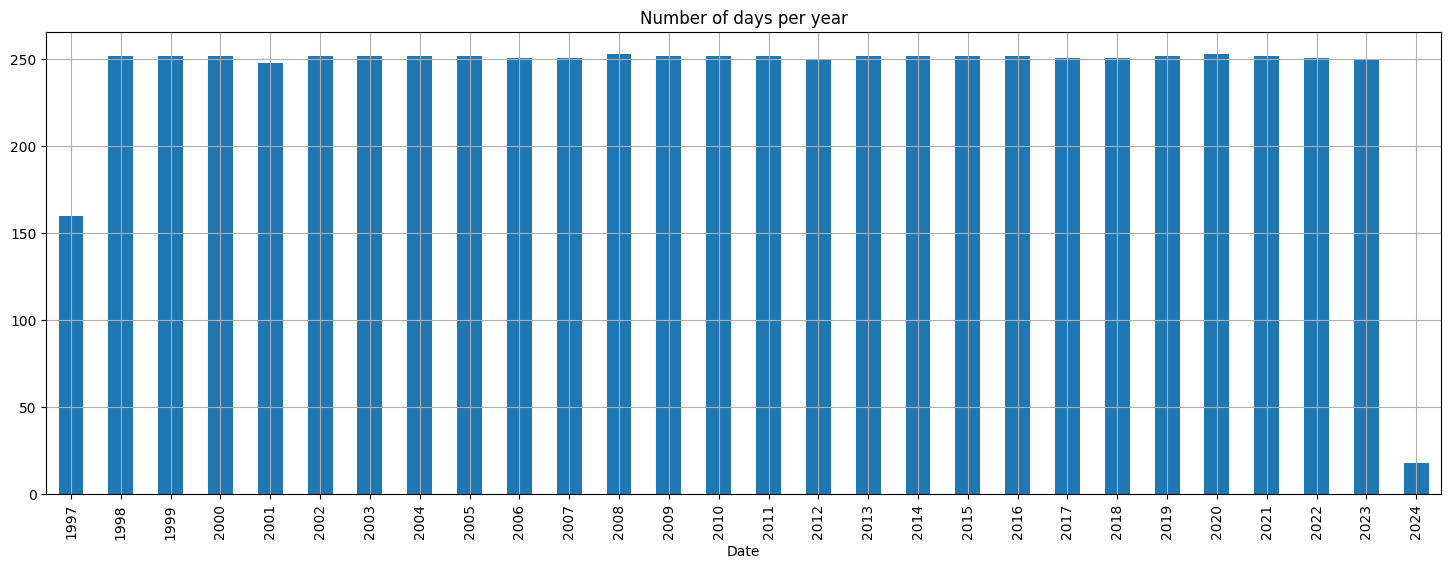

In [17]:
df.groupby(df.index.year).size().plot(kind="bar", figsize=(18, 6), grid=True, title="Number of days per year")
plt.savefig('../reports/figures/Number of days per year.png',dpi=300)

### We typically have approximately 250 entries per year, with the exceptions being 1997 and 2024. For our analysis, we will utilize data spanning from 1998 to the end of 2023.

In [18]:
df = df["1998":"2023"]

In [19]:
def group_by_year_month(df):
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    grouped_df = df.groupby(['Year', 'Month']).mean()
    return grouped_df


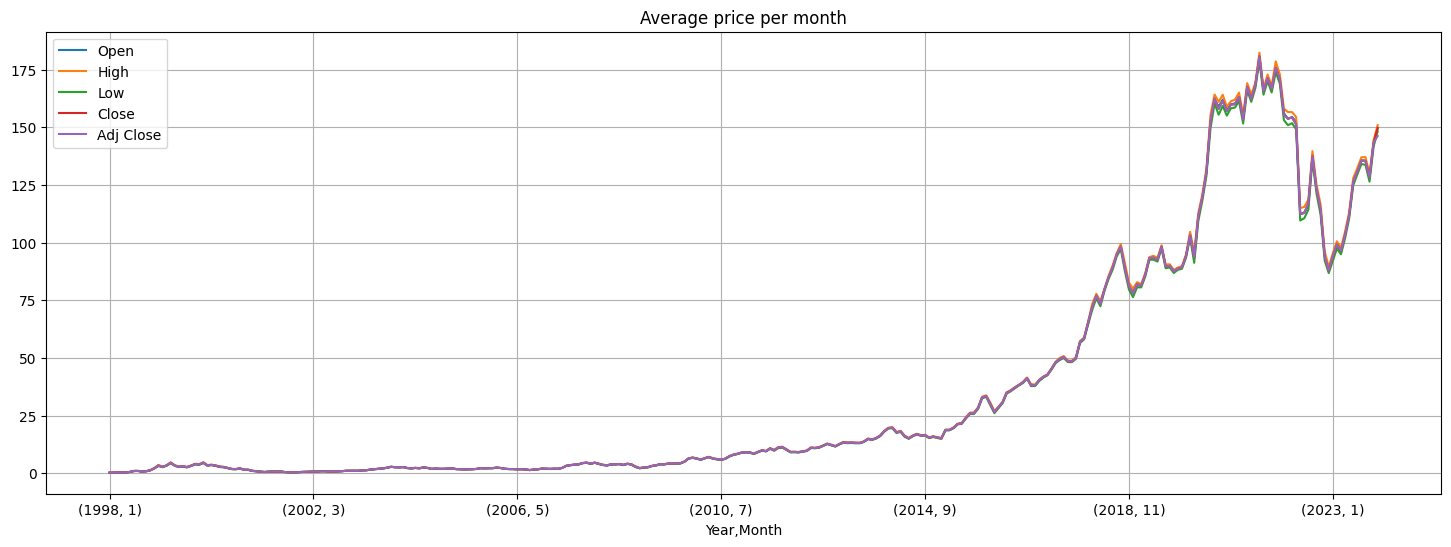

In [20]:
group_by_year_month(df.drop(['Volume'],axis=1)).plot(figsize=(18, 6), grid=True, title="Average price per month")
plt.savefig('../reports/figures/Average price per month.png',dpi=300)

### We observe a significant surge in the stock price around 2020, which can be attributed to the impact of the coronavirus pandemic. With the widespread adoption of online shopping as a result of lockdown measures and social distancing protocols, there was a notable increase in demand for e-commerce services. This shift in consumer behavior likely contributed to the substantial growth in the stock price during this period

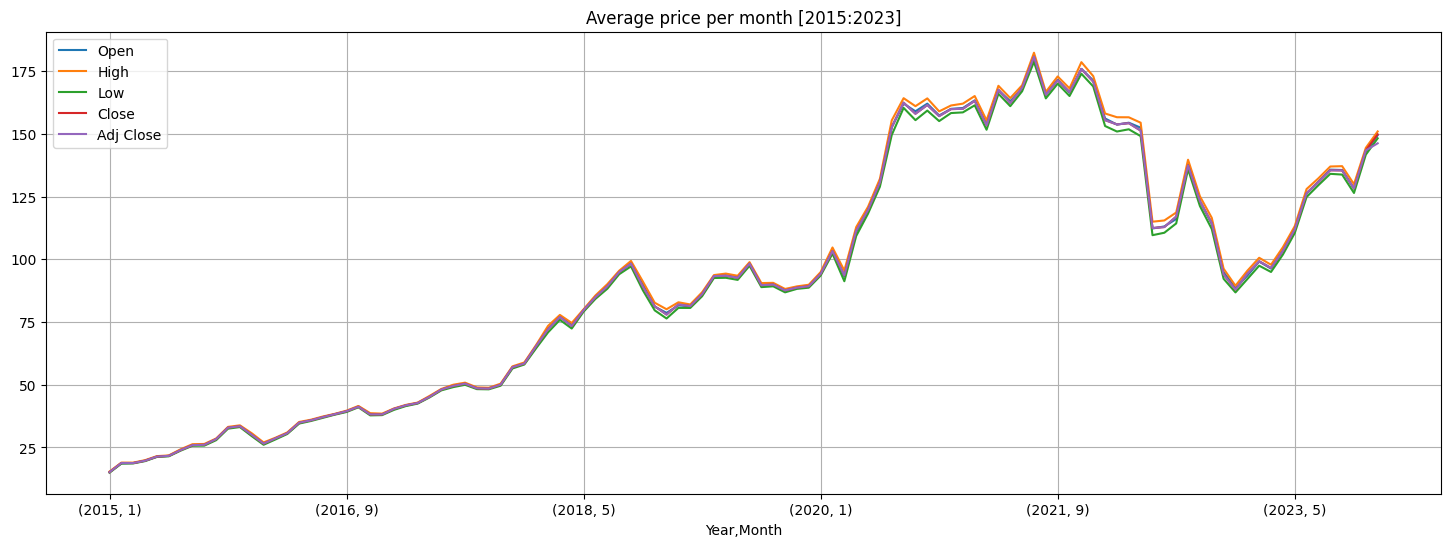

In [21]:
group_by_year_month(df.drop(['Volume'],axis=1)["2015":"2023"]).plot(figsize=(18, 6), grid=True, title="Average price per month [2015:2023]")
plt.savefig('../reports/figures/Average price per month [2015-2023].png',dpi=300)

### Now, we will explore whether there is any weekly, monthly, or yearly seasonality present in the data.

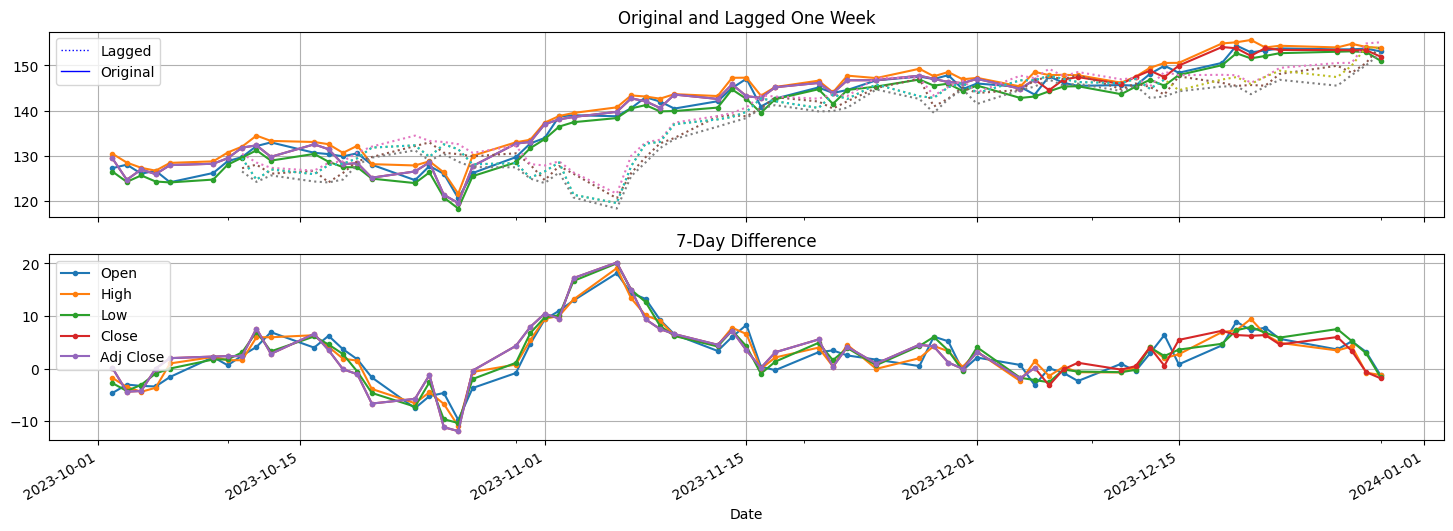

<Figure size 640x480 with 0 Axes>

In [22]:
diff_weekly = df[['Open','High','Low','Close','Adj Close']].diff(7)["2023-10-01":"2024-01-26"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(18, 6))
df[['Open','High','Low','Close','Adj Close']]["2023-10-01":"2024-01-26"].plot(ax=axs[0], marker=".")  # original time series
df[['Open','High','Low','Close','Adj Close']]["2023-10-01":"2024-01-26"].shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_weekly.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series

legend_elements = [Line2D([0], [0], color='b', lw=1,linestyle=":", label='Lagged'),
                   Line2D([0], [0], color='b', lw=1, label='Original')]
axs[0].legend(handles=legend_elements, loc='best')
axs[0].set_title('Original and Lagged One Week')
axs[1].set_title('7-Day Difference')


plt.show()
plt.savefig('../reports/figures/Weekly Seasonality.png',dpi=300)


### From the observations in the above figure, it's evident that the dashed line and solid line diverge significantly. Additionally, the difference between the original data and its lagged version is not close to zero (which could be approximated by the gradient). These findings suggest that there is no weekly seasonality present in the data.

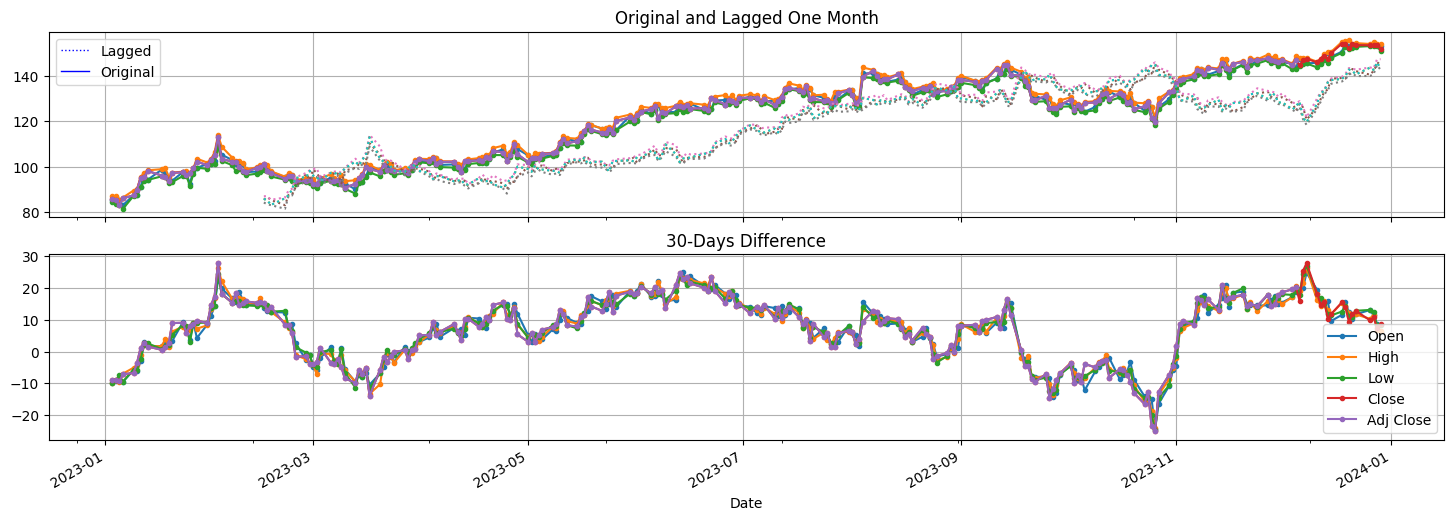

<Figure size 640x480 with 0 Axes>

In [23]:
diff_mothly = df[['Open','High','Low','Close','Adj Close']].diff(30)["2023-01-01":"2024-01-26"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(18, 6))
df[['Open','High','Low','Close','Adj Close']]["2023-01-01":"2024-01-26"].plot(ax=axs[0], legend=False, marker=".")  # original time series
df[['Open','High','Low','Close','Adj Close']]["2023-01-01":"2024-01-26"].shift(30).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_mothly.plot(ax=axs[1], grid=True, marker=".")

legend_elements = [Line2D([0], [0], color='b', lw=1,linestyle=":", label='Lagged'),
                   Line2D([0], [0], color='b', lw=1, label='Original')]
axs[0].legend(handles=legend_elements, loc='best')
axs[0].set_title('Original and Lagged One Month')
axs[1].set_title('30-Days Difference')

plt.show()
plt.savefig('../reports/figures/Monthly Seasonality.png',dpi=300)

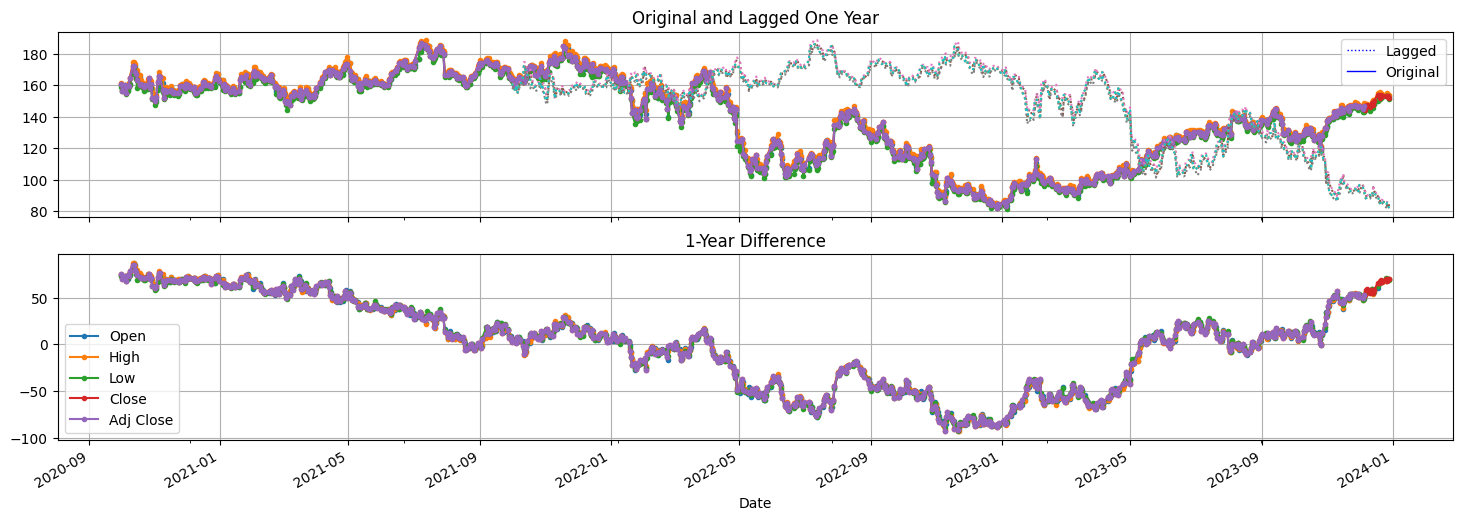

<Figure size 640x480 with 0 Axes>

In [24]:
diff_yearly = df[['Open','High','Low','Close','Adj Close']].diff(252)["2020-10-01":"2024-01-26"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(18, 6))
df[['Open','High','Low','Close','Adj Close']]["2020-10-01":"2024-01-26"].plot(ax=axs[0], legend=False, marker=".")  # original time series
df[['Open','High','Low','Close','Adj Close']]["2020-10-01":"2024-01-26"].shift(252).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_yearly.plot(ax=axs[1], grid=True, marker=".")

legend_elements = [Line2D([0], [0], color='b', lw=1,linestyle=":", label='Lagged'),
                   Line2D([0], [0], color='b', lw=1, label='Original')]
axs[0].legend(handles=legend_elements, loc='best')
axs[0].set_title('Original and Lagged One Year')
axs[1].set_title('1-Year Difference')

plt.show()

plt.savefig('../reports/figures/Yearly Seasonality.png',dpi=300)

### Furthermore, the analysis of yearly and monthly figures indicates the absence of any discernible monthly or yearly seasonality

In [25]:
df=df.dropna()

In [26]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6524 entries, 1998-01-02 to 2023-12-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6524 non-null   float64
 1   High       6524 non-null   float64
 2   Low        6524 non-null   float64
 3   Close      6524 non-null   float64
 4   Adj Close  6524 non-null   float64
 5   Volume     6524 non-null   float64
dtypes: float64(6)
memory usage: 356.8 KB


In [27]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6524.000000,6524.000000,6524.000000,6524.000000,6524.000000,6.524000e+03
mean,34.860062,35.279859,34.404636,34.850825,34.850825,1.416636e+08
std,50.178171,50.767876,49.530689,50.150486,50.150486,1.390917e+08
min,0.208333,0.219271,0.207292,0.213021,0.213021,1.762600e+07
25%,2.135875,2.183625,2.108875,2.140000,2.140000,6.816900e+07
50%,8.571750,8.662500,8.457750,8.570250,8.570250,1.050850e+08
75%,48.050124,48.408875,47.723875,48.067501,48.067501,1.596620e+08
max,187.199997,188.654007,184.839493,186.570496,186.570496,2.086584e+09


### Now, let's examine the boxplots of the columns.

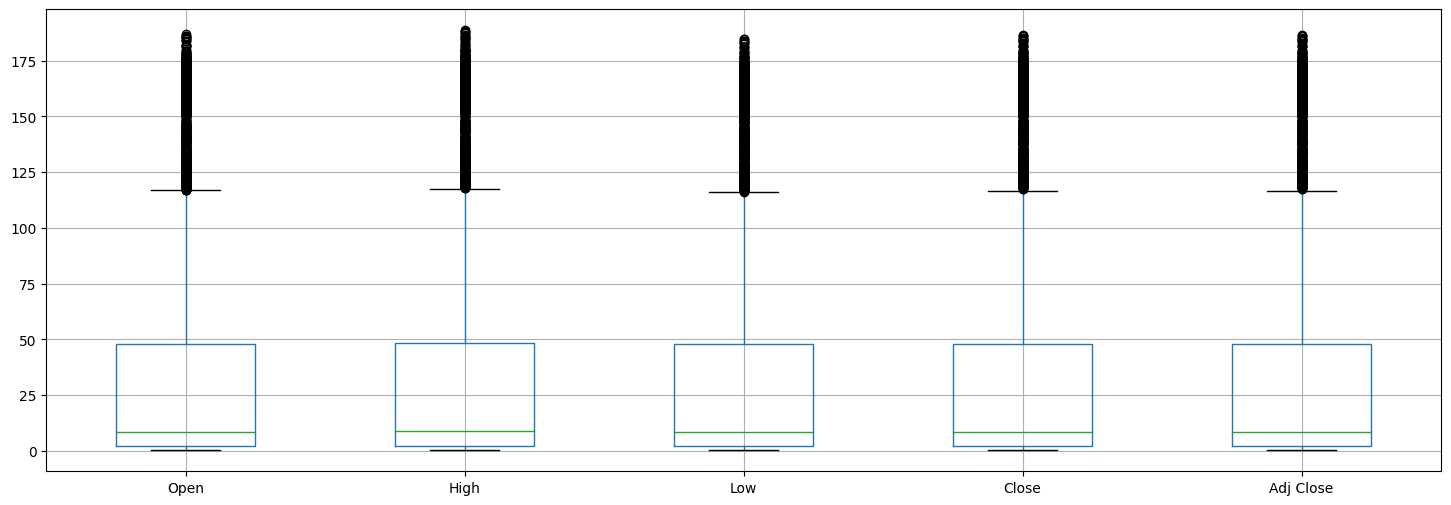

In [28]:
df.drop(['Volume'],axis=1).boxplot(figsize=(18,6))
plt.savefig('../reports/figures/Boxplot.png',dpi=300)


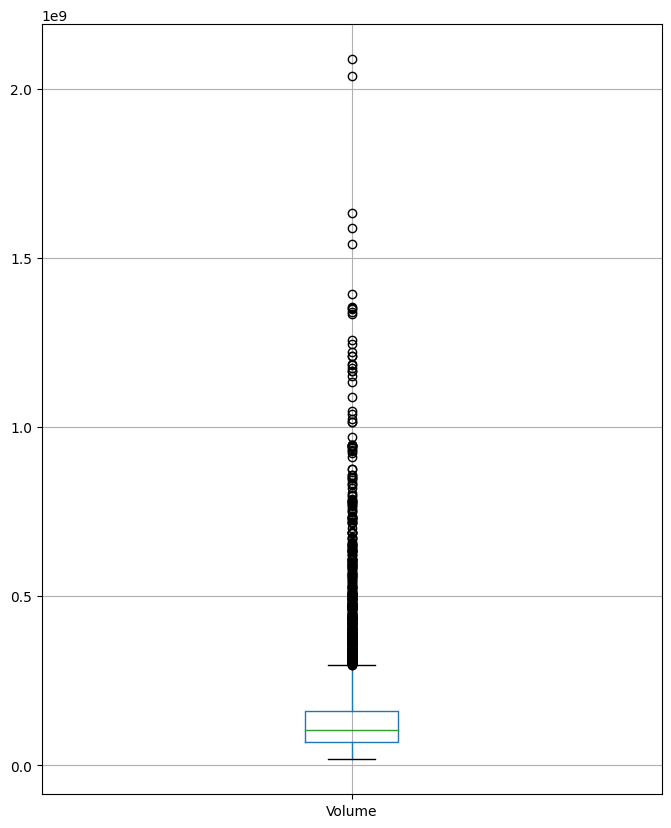

In [29]:
df[['Volume']].boxplot(figsize=(8,10))
plt.savefig('../reports/figures/Boxplot Volume.png',dpi=300)

### Now, let's examine the distribution of the data.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_34608\595758490.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=axs[row, col], kde=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_34608\595758490.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=axs[row, col], 

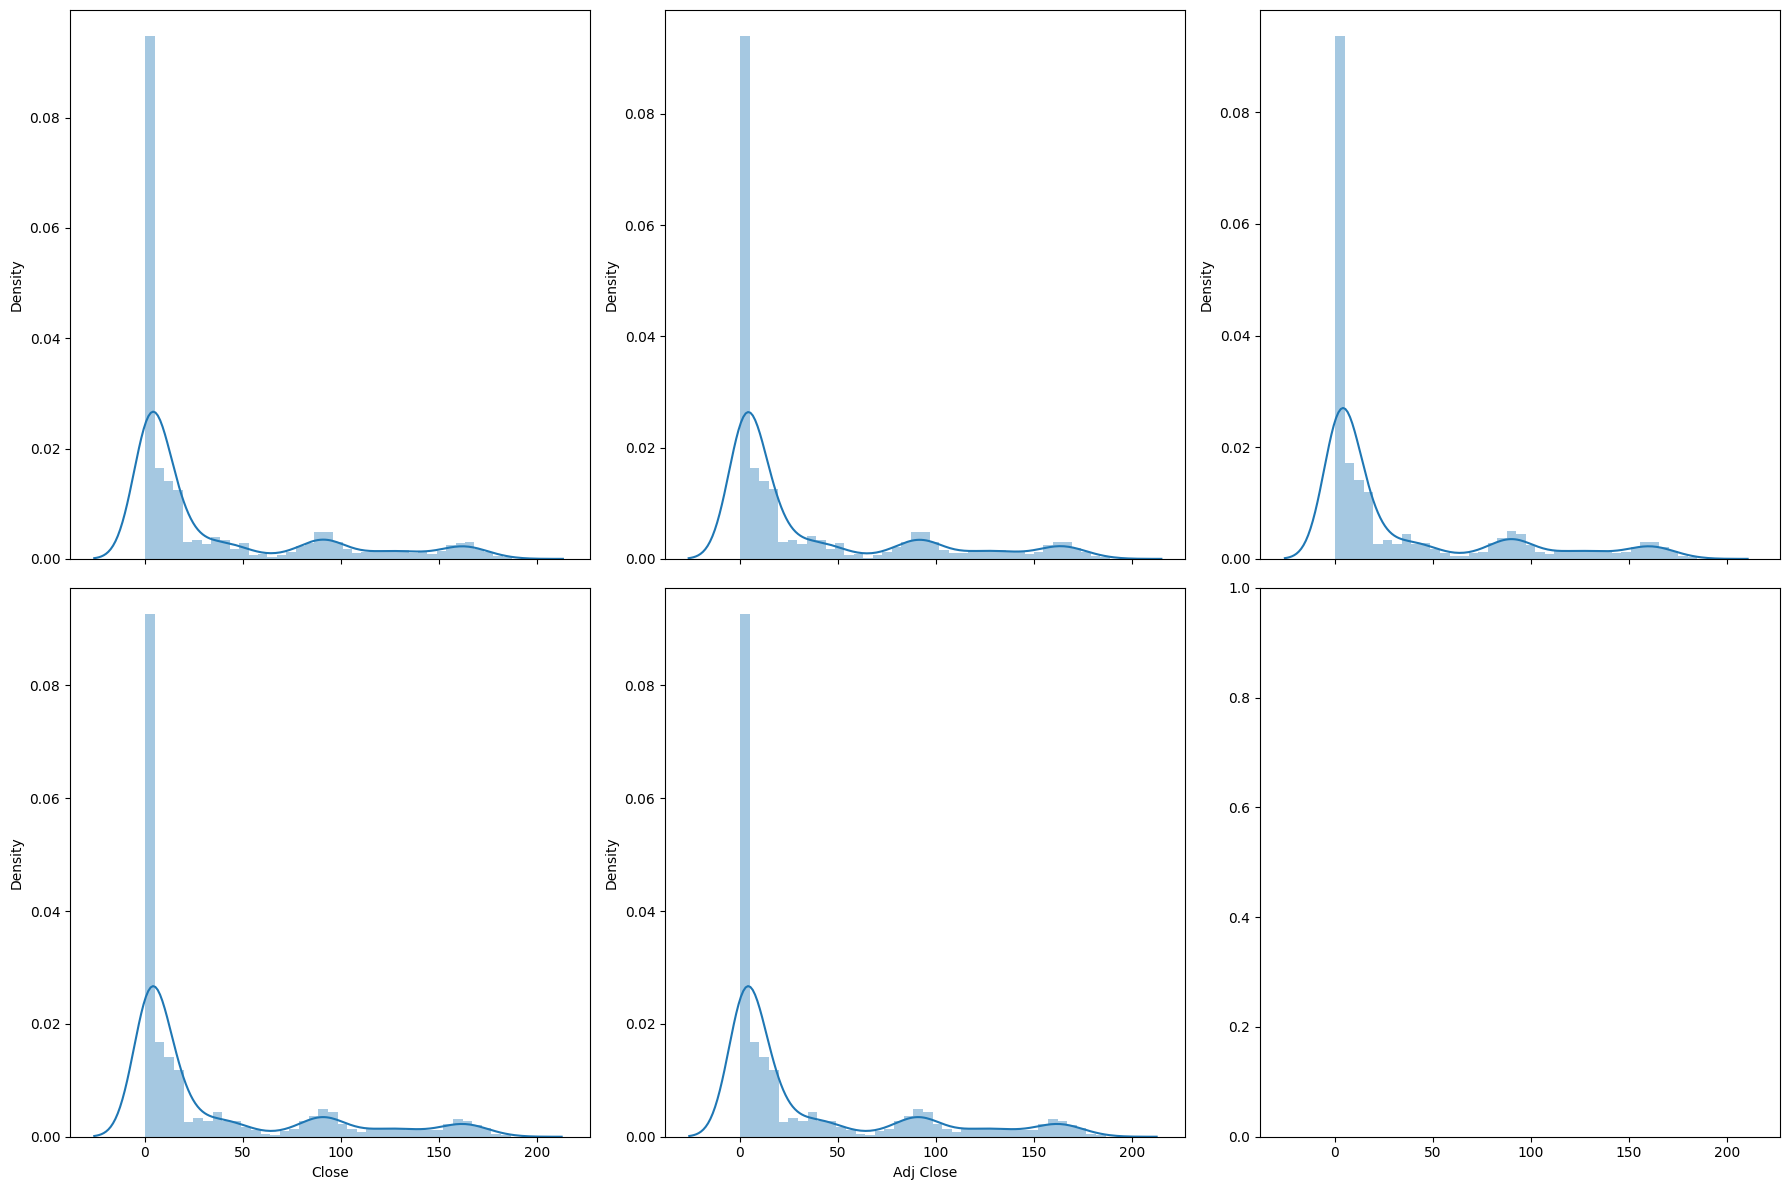

In [31]:
fig, axs = plt.subplots(2, 3, sharex=True, figsize=(18, 12))

# Iterate over the columns
for i, column in enumerate(df.drop(['Volume'],axis=1).columns):
    # Calculate the subplot position
    row = i // 3
    col = i % 3

    sns.distplot(df[column], ax=axs[row, col], kde=True)
    
plt.tight_layout()
plt.savefig('../reports/figures/Distribution.png',dpi=300)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_34608\2474225533.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Volume'], kde=True)


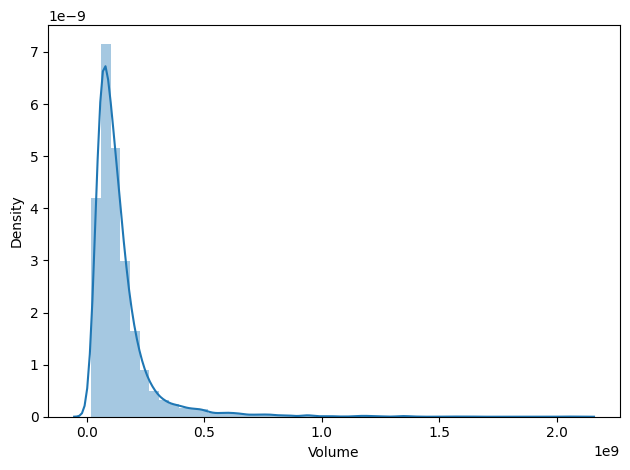

In [32]:
sns.distplot(df['Volume'], kde=True)    
plt.tight_layout()
plt.savefig('../reports/figures/Distribution Volume.png',dpi=300)

# <div id="Data-Preprocessing">Data-Preprocessing</div>

### For the sake of simplicity and time efficiency, we will focus solely on the 'Close' column. You may apply the same approach to the remaining columns as needed.

### The closing price is considered [the most accurate valuation of a stock](https://www.investopedia.com/terms/c/closingprice.asp#:~:text=The%20closing%20price%20is%20considered,market%20sentiment%20toward%20that%20stock) or other security until trading resumes on the next trading day.

### The closing price on one day can be compared to the closing price on the previous day, 30 days earlier or a year earlier, to measure the changes in market sentiment toward that stock.

In [34]:
close_df=df[['Close']]

In [35]:
close_scaler = MinMaxScaler()
close_scaled_data = close_scaler.fit_transform(close_df)


### we will use every 56-day window from the past as training data, and the target for each window will be the value immediately following it.

In [23]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [24]:
close_sequencies, close_labels = create_sequences(close_scaled_data, 56)


In [25]:
def get_train_valid_test_split(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, shuffle=True, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=42)
    return X_train,X_valid, X_test, y_train,y_valid, y_test

In [26]:
close_X_train, close_X_valid, close_X_test, close_y_train, close_y_valid, close_y_test = get_train_valid_test_split(
    close_sequencies, close_labels)

In [27]:
seq_length = 56

def get_train_valid_test_datasets(X_train,X_valid, X_test, y_train,y_valid, y_test):
    train_ds=tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds=train_ds.batch(32)
    valid_ds=tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    valid_ds=valid_ds.batch(32)
    test_ds=tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_ds=test_ds.batch(32)
    return train_ds,valid_ds,test_ds
    

In [28]:
close_train_ds, close_valid_ds, close_test_ds = get_train_valid_test_datasets(
    close_X_train, close_X_valid, close_X_test, close_y_train, close_y_valid, close_y_test)

# <div id="Model-Development">Model Development</div>

In [29]:
# callbacks

checkpoint_path = "model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_mae",
                                                         save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_mae doesn't improve for 50 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mae",  # watch the val mae metric
                                                  patience=50,
                                                  restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=30, min_lr=1e-6)

In [ ]:
def fit_and_evaluate(model, train_set, valid_set, test_set, learning_rate, tensorborad_name, epochs=200):
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[
                            early_stopping,  # Uncomment this line if you want to use early stopping
                            create_tensorboard_callback("training_logs",
                                                        tensorborad_name),
                            checkpoint_callback
                            # reduce_lr
                        ])
    valid_loss, valid_mae = model.evaluate(valid_set)
    test_loss, test_mae = model.evaluate(test_set)
    model.save(f"../models/{tensorborad_name}_model.h5")
    print(f"=Valid mae: {valid_mae * 1e6}")
    print(f"Test mae: {test_mae * 1e6}")
    print(model.summary())
    return valid_mae * 1e6

In [ ]:
def get_data(dataset):
    data = []
    for element in dataset:
        data.append(element[1].numpy())
    return data

In [ ]:
def flatten_data(data):
    flattened = []

    for arr in data[0]:
        for val in arr:
            if val is not None:
                flattened.append(val)

    return np.array(flattened)

In [ ]:
def get_real_pred_df(scalar, model, sequencies, labels, indices):
    preds = scalar.inverse_transform(model.predict(sequencies))
    labels = scalar.inverse_transform(labels)
    dataframe = pd.DataFrame(
        {'Real': labels.flatten(), 'Predictions': preds.flatten()})
    dataframe.index = indices
    return dataframe

In [ ]:
close_data = get_data(close_test_ds)

In [ ]:
close_flattened = close_scaler.inverse_transform([flatten_data(close_data)])

## <div id="Deep-RNN">Deep RNN</div>
![image.png](https://i.ibb.co/hYXzB7W/Screenshot-2024-01-26-145751.png)

In [30]:
close_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.SimpleRNN(50, return_sequences=True),
    tf.keras.layers.SimpleRNN(1)
])

In [100]:
fit_and_evaluate(close_model, close_train_ds, close_valid_ds, close_test_ds, learning_rate=0.02,tensorborad_name="Close",epochs=100)

Saving TensorBoard log files to: training_logs/Open/20240128-231455
21/21 [==============================] - 0s 9ms/step - loss: 9.1860e-05 - mae: 0.0109
=Valid mae: 11080.177500844002
Test mae: 10889.486409723759
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_24 (SimpleRNN)   (None, None, 32)          1088      
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_26 (SimpleRNN)   (None, 1)                 34        
                                                                 
Total params: 3202 (12.51 KB)
Trainable params: 3202 (12.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


/home/mohamed/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11080.177500844002

In [61]:
close_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_24 (SimpleRNN)   (None, None, 32)          1088      
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_26 (SimpleRNN)   (None, 1)                 34        
                                                                 
Total params: 3202 (12.51 KB)
Trainable params: 3202 (12.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [157]:
close_preds = close_scaler.inverse_transform(close_model.predict(close_test_ds))

 1/21 [>.............................] - ETA: 0s

21/21 [==============================] - 0s 10ms/step


In [161]:
close_df_predictions = get_real_pred_df(close_scaler,close_model,close_sequencies[-200:],close_labels[-200:],close_df[-200:].index)

In [ ]:
close_df_predictions.plot(grid=True, marker='.',figsize=(18,6))
plt.savefig('../reports/figures/DeepRNN_Predictions.png',dpi=300)

## <div id="LSTM">LSTM</div>
![image.png](https://i.ibb.co/NWj1rgX/Screenshot-2024-01-26-182735.png)

#### The long short-term memory (LSTM) cell can be use for tackling the short-term memory problem

#### As the long-term state c(t–1). traverses the network from left to right, you can see that it first goes through a forget gate, dropping some memories, and then it adds some new memories via the addition operation (which adds the memories that were selected by an input gate). The result c(t) is sent straight out, without any further transformation. So, at each time step, some memories are dropped and some memories are added. Moreover, after the addition operation, the long-term state is copied and passed through the tanh function, and then the result is filtered by the output gate. This produces the short-term state h(t) (which is equal to the cell’s output for this time step, y(t)).

#### First, the current input vector x(t) and the previous short-term state h(t–1) are fed to four different fully connected layers. They all serve a different purpose:

- The main layer is the one that outputs g(t). It has the usual role of
analyzing the current inputs x(t) and the previous (short-term) state h(t–1).
In a basic cell, there is nothing other than this layer, and its output goes
straight out to y(t) and h(t). But in an LSTM cell, this layer’s output does
not go straight out; instead its most important parts are stored in the long-term state (and the rest is dropped).
- The three other layers are gate controllers. Since they use the logistic
activation function, the outputs range from 0 to 1. As you can see, the
gate controllers’ outputs are fed to element-wise multiplication
operations: if they output 0s they close the gate, and if they output 1s they
open it. Specifically:
    - The forget gate (controlled by f(t)) controls which parts of
    the long-term state should be erased.
    - The input gate (controlled by i(t)) controls which parts of
    g(t) should be added to the long-term state.
    - Finally, the output gate (controlled by o(t)) controls which
    parts of the long-term state should be read and output at
    this time step, both to h(t) and to y(t).
    
#### In short, an LSTM cell can learn to recognize an important input (that’s the role of the input gate), store it in the long-term state, preserve it for as long as it is needed (that’s the role of the forget gate), and extract it whenever it is needed. This explains why these cells have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.

In [ ]:
close_model_LSTM = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.SimpleRNN(1)
])

In [ ]:
fit_and_evaluate(close_model_LSTM, close_train_ds, close_valid_ds, close_test_ds, learning_rate=0.02,tensorborad_name="close_LSTM",epochs=100)

In [ ]:
close_model_LSTM.summary()

In [ ]:
close_preds_LSTM = close_scaler.inverse_transform(close_model_LSTM.predict(close_test_ds))

In [ ]:
close_df_predictions_LSTM = get_real_pred_df(close_scaler,close_model_LSTM,close_sequencies[-200:],close_labels[-200:],close_df[-200:].index)

In [ ]:
close_df_predictions_LSTM.plot(grid=True, marker='.',figsize=(18,6))
plt.savefig('../reports/figures/LSTM_Predictions.png',dpi=300)

## <div id="GRU">GRU</div>
![image.png](https://i.ibb.co/NZbwsWb/Screenshot-2024-01-26-185232.png)

#### The gated recurrent unit (GRU) cell is a simplified version of the LSTM cell, and it seems to perform just as well (which explains its growing popularity). These are the main simplifications:

- Both state vectors are merged into a single vector h(t).
- A single gate controller z(t) controls both the forget gate and the input
gate. If the gate controller outputs a 1, the forget gate is open (= 1) and
the input gate is closed (1 – 1 = 0). If it outputs a 0, the opposite happens.
In other words, whenever a memory must be stored, the location where it
will be stored is erased first. This is actually a frequent variant to the
LSTM cell in and of itself.
- There is no output gate; the full state vector is output at every time step.
However, there is a new gate controller r(t) that controls which part of the
previous state will be shown to the main layer (g(t)).

In [ ]:
close_model_GRU = tf.keras.Sequential([
    tf.keras.layers.GRU(64, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(1)
])

In [ ]:
fit_and_evaluate(close_model_GRU, close_train_ds, close_valid_ds, close_test_ds, learning_rate=0.02,tensorborad_name="close_GRU",epochs=100)

In [ ]:
close_model_GRU.summary()

In [ ]:
close_preds_GRU = close_scaler.inverse_transform(close_model_GRU.predict(close_test_ds))

In [ ]:
close_df_predictions_GRU = get_real_pred_df(close_scaler,close_model_GRU,close_sequencies[-200:],close_labels[-200:],close_df[-200:].index)

In [ ]:
close_df_predictions_GRU.plot(grid=True, marker='.',figsize=(18,6))
plt.savefig('../reports/figures/GRU_Predictions.png',dpi=300)

# <div id="Models-Comparision">Models Comparison</div>

In [ ]:
mse_RNN = mean_squared_error(
    close_df_predictions['Real'].values, close_df_predictions['Predictions'].values)
mse_LSTM = mean_squared_error(
    close_df_predictions_LSTM['Real'].values, close_df_predictions_LSTM['Predictions'].values)
mse_GRU = mean_squared_error(
    close_df_predictions_GRU['Real'].values, close_df_predictions_GRU['Predictions'].values)

rmse_RNN = np.sqrt(mse_RNN)
rmse_LSTM = np.sqrt(mse_LSTM)
rmse_GRU = np.sqrt(mse_GRU)

mae_RNN = mean_absolute_error(
    close_df_predictions['Real'].values, close_df_predictions['Predictions'].values)
mae_LSTM = mean_absolute_error(
    close_df_predictions_LSTM['Real'].values, close_df_predictions_LSTM['Predictions'].values)
mae_GRU = mean_absolute_error(
    close_df_predictions_GRU['Real'].values, close_df_predictions_GRU['Predictions'].values)

In [ ]:
models = ['Deep RNN', 'LSTM', 'GRU']

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.bar(models, [mse_RNN, mse_LSTM, mse_GRU], color='blue')
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')

plt.subplot(3, 1, 2)
plt.bar(models, [rmse_RNN, rmse_LSTM, rmse_GRU], color='green')
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')

plt.subplot(3, 1, 3)
plt.bar(models, [mae_RNN, mae_LSTM, mae_GRU], color='orange')
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
plt.savefig('../reports/figures/Model Comparison.png',dpi=300)